In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from salishsea_tools import viz_tools
from scipy.spatial import KDTree
import cmocean as cm
from pathlib import Path
import scipy

### Import data

In [2]:
mesh_ssc = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/OAE/sss150/mesh_mask201702MD.nc')
mesh_sss150bc = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/OAE/sss150/mesh_mask201702MD_No_FR_Ext.nc')
mesh_sss150 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/OAE/sss150/bathymetry_southsalishsea150_update202108210102AUM1.nc')

(350.0, 550.0)

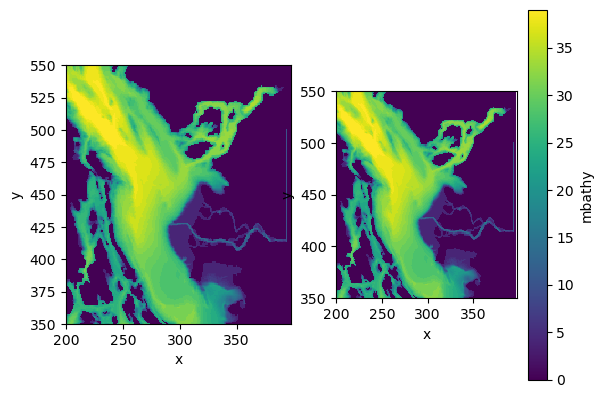

In [3]:
fig,ax = plt.subplots(1,2)

mesh_sss150bc.mbathy.plot(ax=ax[0],add_colorbar=False)
viz_tools.set_aspect(ax[0])
ax[0].set_xlim((200,398))
ax[0].set_ylim((350,550))

mesh_ssc.mbathy.plot(ax=ax[1])
viz_tools.set_aspect(ax[1])
ax[1].set_xlim((200,398))
ax[1].set_ylim((350,550))

(350.0, 550.0)

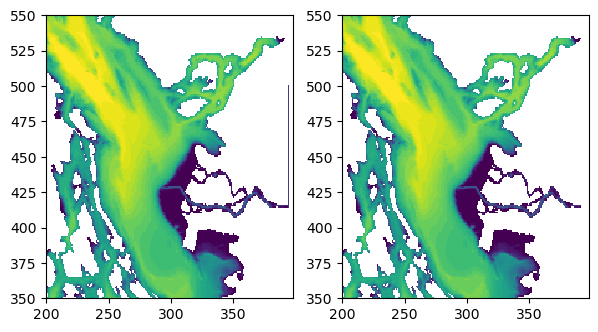

In [4]:
tmask_ssc = 1 - mesh_ssc.tmask[0]
tmask_sss150bc = 1 - mesh_sss150bc.tmask[0]

fig, ax = plt.subplots(1, 2, figsize=(7, 7))
mbath = np.ma.masked_array(mesh_ssc.mbathy[0], mask=tmask_ssc[0])
ax[0].pcolormesh(mbath)
viz_tools.set_aspect(ax[0]);
ax[0].set_xlim((200,398))
ax[0].set_ylim((350,550))

mbath_sss150 = np.ma.masked_array(mesh_sss150bc.mbathy[0], mask=tmask_sss150bc[0])
ax[1].pcolormesh(mbath_sss150)
viz_tools.set_aspect(ax[1]);
ax[1].set_xlim((200,398))
ax[1].set_ylim((350,550))

In [6]:
tmask_diff = (tmask_ssc[0] - tmask_sss150bc[0])
tmask_ma = np.ma.masked_array(tmask_diff, mask=tmask_ssc[0])

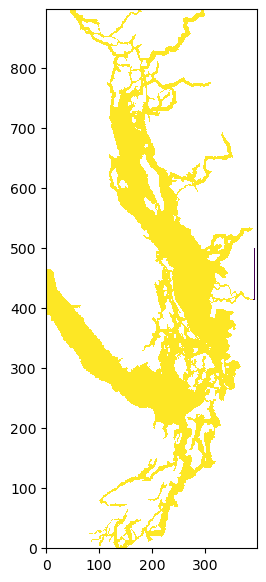

In [7]:
fig,ax = plt.subplots(1, 1, figsize=(5, 7))
ax.pcolormesh(tmask_ma)
viz_tools.set_aspect(ax);

### Bathymetry differences

(350.0, 550.0)

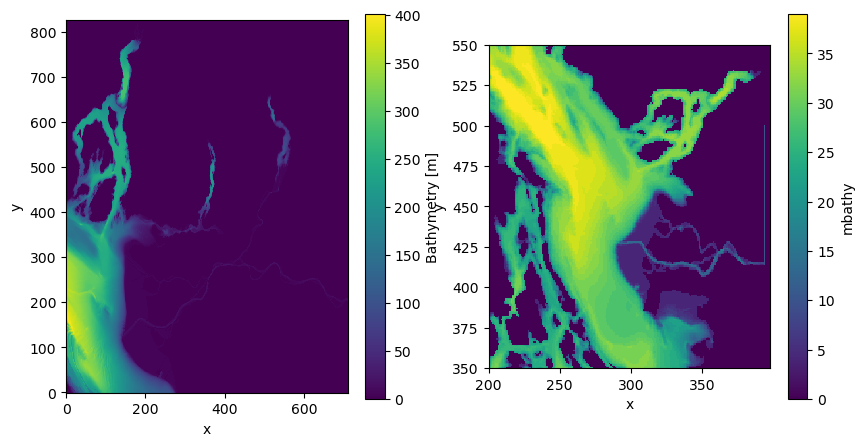

In [8]:
fig,ax = plt.subplots(1,2,figsize=(10,5))

mesh_sss150.Bathymetry.plot(ax=ax[0])
viz_tools.set_aspect(ax[0])
# ax[0].set_xlim((200,398))
# ax[0].set_ylim((350,550))

mesh_ssc.mbathy.plot(ax=ax[1])
viz_tools.set_aspect(ax[1])
ax[1].set_xlim((200,398))
ax[1].set_ylim((350,550))

/tmp/ipykernel_20742/3318149771.py:9: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  mesh2 = ax[1].pcolormesh(mesh_ssc.nav_lon,mesh_ssc.nav_lat,mesh_ssc.mbathy[0])


(48.95, 49.75)

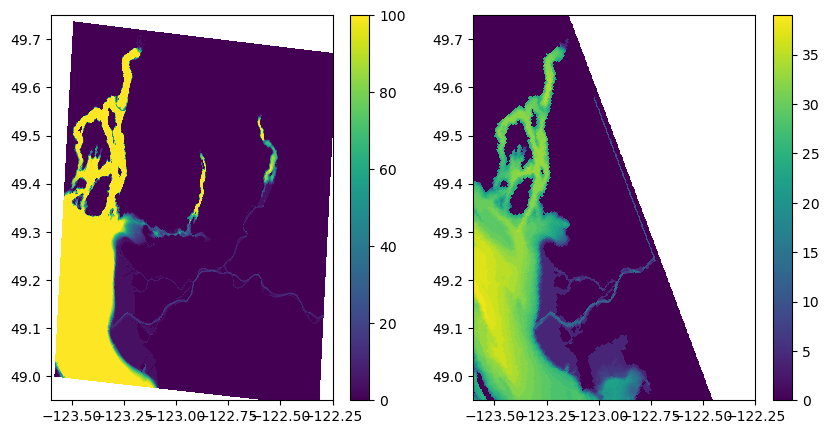

In [9]:
fig,ax = plt.subplots(1,2,figsize=(10,5))

mesh = ax[0].pcolormesh(mesh_sss150.nav_lon,mesh_sss150.nav_lat,mesh_sss150.Bathymetry)
cb = fig.colorbar(mesh,ax=ax[0])
mesh.set_clim(0,100)
ax[0].set_xlim(-123.6,-122.25)
ax[0].set_ylim(48.95,49.75)

mesh2 = ax[1].pcolormesh(mesh_ssc.nav_lon,mesh_ssc.nav_lat,mesh_ssc.mbathy[0])
cb = fig.colorbar(mesh2,ax=ax[1])
# mesh2.set_clim(0,150)
ax[1].set_xlim(-123.6,-122.25)
ax[1].set_ylim(48.95,49.75)

In [10]:
ssc_depths = np.zeros_like(mesh_ssc.mbathy[0])
depths_idx = mesh_ssc.gdepw_1d[0].values

for i in range(898):
    for j in range(398):
        ssc_depths[i,j] = depths_idx[mesh_ssc.mbathy[0,i,j].values]

/tmp/ipykernel_20742/3318973686.py:9: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  mesh = ax[1].pcolormesh(mesh_ssc.nav_lon,mesh_ssc.nav_lat,ssc_depths)


(48.95, 49.75)

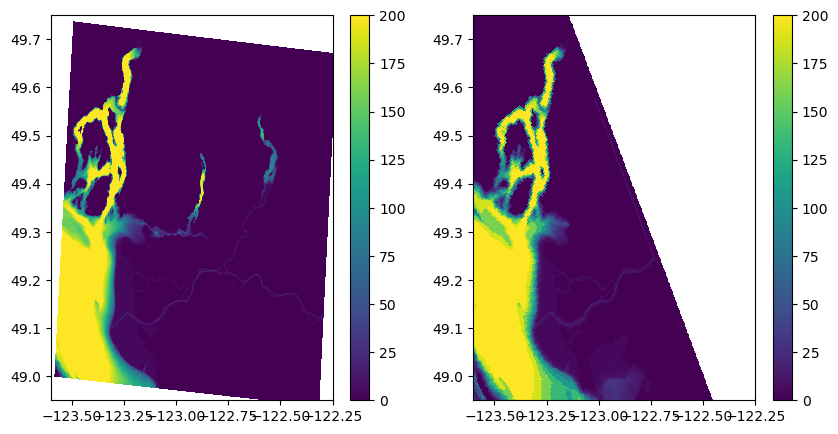

In [11]:
fig,ax = plt.subplots(1,2,figsize=(10,5))

mesh = ax[0].pcolormesh(mesh_sss150.nav_lon,mesh_sss150.nav_lat,mesh_sss150.Bathymetry)
cb = fig.colorbar(mesh,ax=ax[0])
mesh.set_clim(0,200)
ax[0].set_xlim(-123.6,-122.25)
ax[0].set_ylim(48.95,49.75)

mesh = ax[1].pcolormesh(mesh_ssc.nav_lon,mesh_ssc.nav_lat,ssc_depths)
cb = fig.colorbar(mesh,ax=ax[1])
mesh.set_clim(0,200)
ax[1].set_xlim(-123.6,-122.25)
ax[1].set_ylim(48.95,49.75)


In [12]:
# Extract coordinates and bathymetry data
lat_ssc = mesh_ssc['nav_lat'].values
lon_ssc = mesh_ssc['nav_lon'].values
depth_ssc = ssc_depths

lat_sss150 = mesh_sss150['nav_lat'].values
lon_sss150 = mesh_sss150['nav_lon'].values

# Flatten the lat/lon arrays
points_ssc = np.column_stack((lat_ssc.ravel(), lon_ssc.ravel()))
points_sss150 = np.column_stack((lat_sss150.ravel(), lon_sss150.ravel()))

# Build KDTree 
tree = KDTree(points_ssc)

# Find the closest point in ssc for sss150
distances, indices = tree.query(points_sss150)

# Map bathymetry values
closest_bathymetry = depth_ssc.ravel()[indices]

# Reshape back to sss150 dims
closest_bathymetry_reshaped = closest_bathymetry.reshape(lat_sss150.shape)

#Difference
diff_bathy = mesh_sss150.Bathymetry - closest_bathymetry_reshaped


/tmp/ipykernel_20742/2671466376.py:21: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  mesh = ax2.pcolormesh(mesh_ssc.nav_lon,mesh_ssc.nav_lat,ssc_depths,cmap = cm.cm.rain)


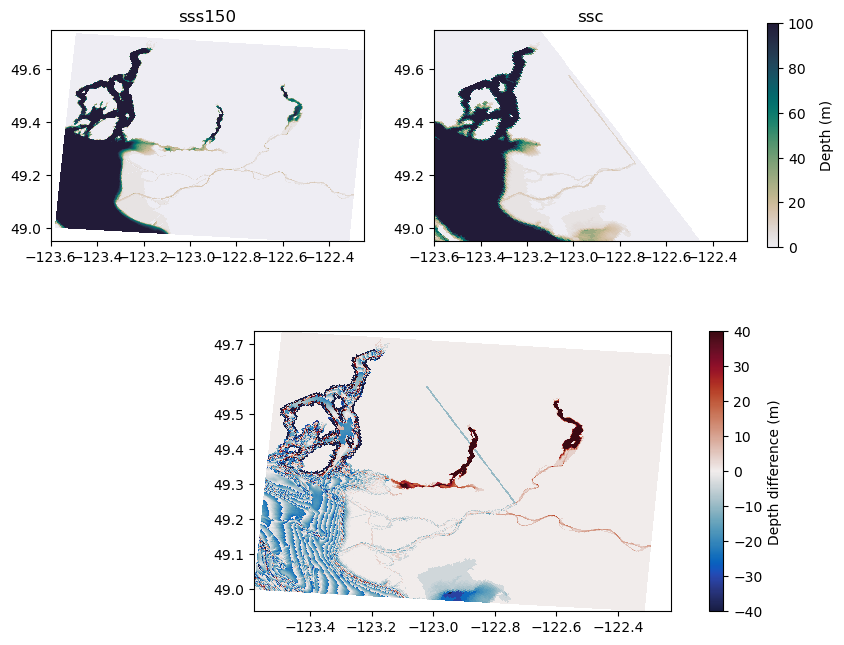

In [13]:
fig = plt.figure(figsize=(10, 8))
gs = fig.add_gridspec(2, 2,width_ratios=[1,1.25])

# Define subplots
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax_center = fig.add_subplot(gs[1, :])

mesh = ax1.pcolormesh(mesh_sss150.nav_lon,mesh_sss150.nav_lat,mesh_sss150.Bathymetry,cmap=cm.cm.rain)
# cb = fig.colorbar(mesh,ax=ax[0])
mesh.set_clim(0,100)
ax1.set_xlim(-123.6,-122.25)
ax1.set_ylim(48.95,49.75)
viz_tools.set_aspect(ax1);
ax1.set_title('sss150')

# mesh = ax2.pcolormesh(mesh_sss150.nav_lon,mesh_sss150.nav_lat,closest_bathymetry_reshaped,cmap=cm.cm.rain)
# cb = fig.colorbar(mesh,ax=ax2)
# mesh.set_clim(0,300)

mesh = ax2.pcolormesh(mesh_ssc.nav_lon,mesh_ssc.nav_lat,ssc_depths,cmap = cm.cm.rain)
cb = fig.colorbar(mesh,ax=ax2,shrink=0.8)
mesh.set_clim(0,100)
ax2.set_xlim(-123.6,-122.25)
ax2.set_ylim(48.95,49.75)
viz_tools.set_aspect(ax2);
cb.set_label('Depth (m)')
ax2.set_title('ssc')

mesh = ax_center.pcolormesh(mesh_sss150.nav_lon,mesh_sss150.nav_lat,diff_bathy,cmap = cm.cm.balance)
cb = fig.colorbar(mesh,ax=ax_center)
mesh.set_clim(-40,40)
viz_tools.set_aspect(ax_center)
cb.set_label('Depth difference (m)');

### Check grid refinements

In [37]:
coords_paths = {
    "sss150": '/ocean/cstang/MOAD/analysis-camryn/OAE/sss150/coordinates_southsalishsea150_20210709.nc',
}

In [15]:
pnw_coast_paths = {
    "coastline": Path("/ocean/rich/more/mmapbase/bcgeo/PNW.mat"),
    "rivers": Path("/ocean/rich/more/mmapbase/bcgeo/PNWrivers.mat"),
}

In [34]:
scipy.io.loadmat(pnw_coast_paths["coastline"]);

In [17]:
coastline = scipy.io.loadmat(pnw_coast_paths["coastline"])["ncst"]

In [35]:
scipy.io.loadmat(pnw_coast_paths["rivers"]);

In [19]:
rivers = scipy.io.loadmat(pnw_coast_paths["rivers"])["ncst"]

#### Look @ warping

(49.15, 49.25)

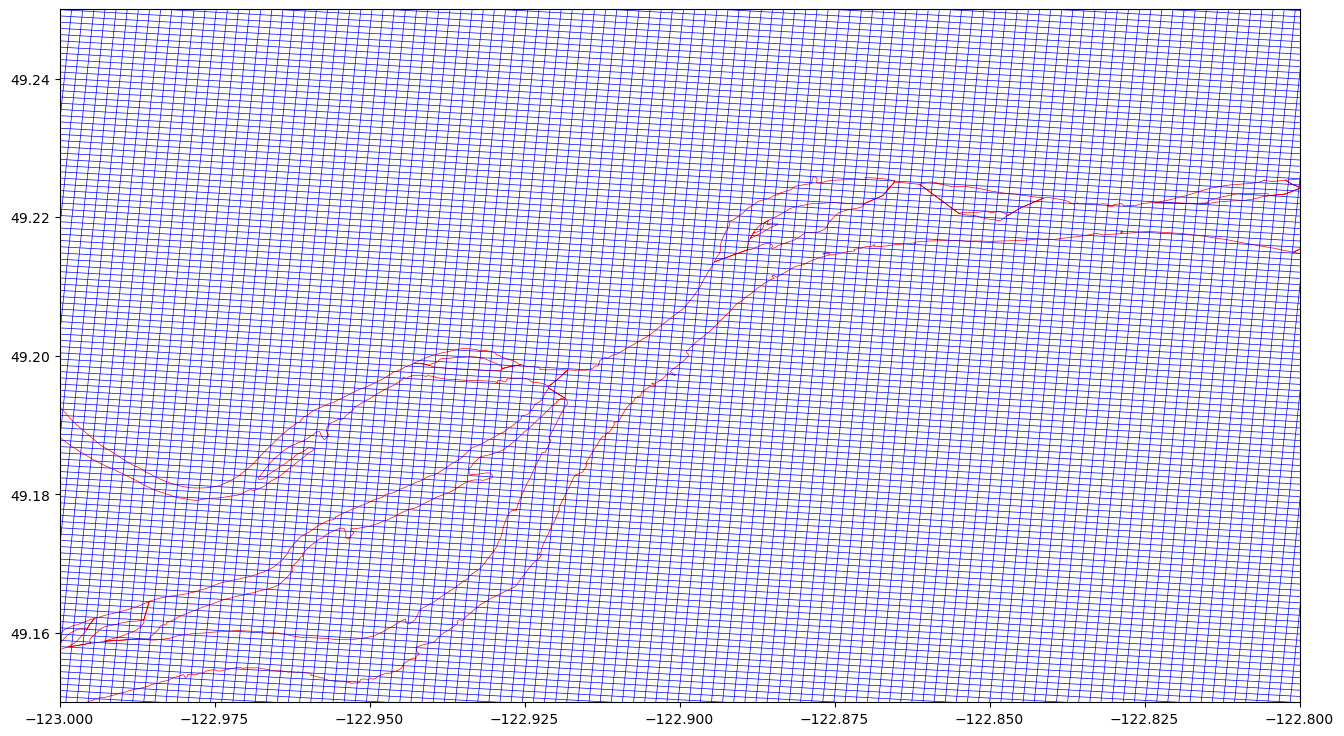

In [36]:
sss150_coords = xr.open_dataset(coords_paths["sss150"])

glamf, gphif = sss150_coords.glamf, sss150_coords.gphif

fig, ax = plt.subplots(1, 1, figsize=(16, 9))
ax.plot(coastline[:, 0], coastline[:, 1], color="red", linewidth=0.5)
ax.plot(rivers[:, 0], rivers[:, 1], color="red", linewidth=0.5)

# sss150 domain boundaries
ax.plot(glamf[0, :], gphif[0, :], color="black")  # south
ax.plot(glamf[:, 0], gphif[:, 0], color="black")  # west
ax.plot(glamf[-1, :], gphif[-1, :], color="black")  # north
ax.plot(glamf[:, -1], gphif[:, -1], color="black")  # east

ax.plot(glamf[100:,:], gphif[100:,:], color="blue", linewidth=0.5)
for row in range(100,826):
    ax.plot(glamf[row,:], gphif[row,:], color="blue", linewidth=0.5)

# # New Westminster area
ax.set_xlim(-123.0, -122.8)
ax.set_ylim(49.15, 49.25)

# Vancouver Harbour
# ax.set_xlim(-123.3, -122.80)
# ax.set_ylim(49.25, 49.45)

Doesn't look like there is any warping / stretching

#### Look @ HRDPS domain

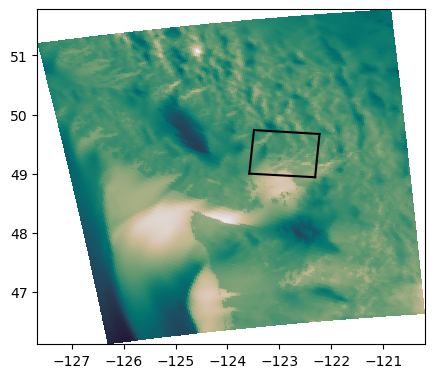

In [27]:
ds = xr.open_dataset('/results/forcing/atmospheric/continental2.5/nemo_forcing/hrdps_y2023m02d23.nc')

fig,ax = plt.subplots(1, 1, figsize=(5, 7))
ax.pcolormesh(ds.nav_lon.values-360,ds.nav_lat,ds.u_wind[0],cmap=cm.cm.rain)
viz_tools.set_aspect(ax);

# sss150 domain boundaries
ax.plot(glamf[0, :], gphif[0, :], color="black")  # south
ax.plot(glamf[:, 0], gphif[:, 0], color="black")  # west
ax.plot(glamf[-1, :], gphif[-1, :], color="black")  # north
ax.plot(glamf[:, -1], gphif[:, -1], color="black")  # east